In [2]:
!pip install pysindy

     |████████████████████████████████| 51kB 4.3MB/s 
     |████████████████████████████████| 22.3MB 1.4MB/s 
     |████████████████████████████████| 256kB 34.3MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: pluggy 0.7.1
    Uninstalling pluggy-0.7.1:
      Successfully uninstalled pluggy-0.7.1
  Found existing installation: pytest 3.6.4
    Uninstalling pytest-3.6.4:
      Successfully uninstalled pytest-3.6.4
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [1]:
import numpy as np
import scipy as sp
import scipy.io

import matplotlib.pyplot as plt
import matplotlib.axes as ax
import matplotlib.gridspec as gridspec

import pickle

from keras.layers import Input, Dense
from keras import regularizers, models, optimizers

from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
import pysindy as ps

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
cd gdrive/MyDrive/Colab Notebooks

/content/gdrive/MyDrive/Colab Notebooks


PCA vs raw/SVD linear autoencoder

In [4]:
#https://github.com/plaut/linear-ae-pca

def LinearAE(y, dimension, learning_rate = 1e-4, regularization = 5e-4, epochs=10):
    input = Input(shape=(y.shape[1],))
    encoded = Dense(dimension, activation='linear',
                    kernel_regularizer=regularizers.l2(regularization))(input)
    decoded = Dense(y.shape[1], activation='linear',
                    kernel_regularizer=regularizers.l2(regularization))(encoded)
    autoencoder = models.Model(input, decoded)
    autoencoder.compile(optimizer=optimizers.Adam(lr=learning_rate), loss='mean_squared_error')
    autoencoder.fit(y, y, epochs=epochs, batch_size=4, shuffle=True)
    (w1,b1,w2,b2)=autoencoder.get_weights()
    return (w1,b1,w2,b2)

In [7]:
def POD(y, dimension):
    y_mean = np.mean(y,axis=0)
    N = np.shape(y)[0]
    U,S,V = np.linalg.svd(np.transpose(y-y_mean))
    
    num_modes = dimension
    U = U[:,0:num_modes]
    total_energy = np.cumsum(S[0:num_modes])[-1]/np.sum(S)
    print("energy retained: " + str(total_energy))

    a = np.matmul(y,U)
    return a, U, y_mean

In [8]:
def loadMGFile(kkk):

    filename = "MGdata_NT_Stall" + str(kkk) + ".pickle"
    file = open(filename, 'rb')
    data = pickle.load(file)
    
    #Extract data from file
    G = data[0][2000:,:]
    Phi = np.expand_dims(data[1],0)
    Phi = Phi[:,2000:]
    Psi = np.expand_dims(data[2],0)
    Psi = Psi[:,2000:]
    T = data[3]
    N = data[4]
    para = data[5]
    gamma = data[6]
    para['gamma'] = gamma
    dt = 0.1
    t = np.arange(0,T-200,dt)

    CombinedData = np.concatenate((np.transpose(G), Phi, Psi), axis=0)
    CombinedData = np.transpose(CombinedData)

    return CombinedData, t

In [9]:
#Calculate POD approximation of G
def restorePOD(SimData, Modes, bias=0):
    original_modes = np.shape(Modes[0])
    num_modes = np.shape(Modes)[1]
    N = np.shape(SimData)[0]
    
    DataApprox = np.matmul(SimData,np.transpose(Modes)) + bias
    return DataApprox

In [10]:
#Code to us LaTeX in Colab
from matplotlib import rc
import matplotlib.pyplot as plt
import matplotlib

rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  cm-super-minimal fonts-adf-accanthis fonts-adf-berenis fonts-adf-gillius
  fonts-adf-universalis fonts-cabin fonts-comfortaa fonts-croscore
  fonts-crosextra-caladea fonts-crosextra-carlito fonts-dejavu-core
  fonts-dejavu-extra fonts-droid-fallback fonts-ebgaramond
  fonts-ebgaramond-extra fonts-font-awesome fonts-freefont-otf
  fonts-freefont-ttf fonts-gfs-artemisia fonts-gfs-complutum fonts-gfs-didot
  fonts-gfs-neohellenic fonts-gfs-olga fonts-gfs-solomos fonts-go
  fonts-junicode fonts-lato fonts-linuxlibertine fonts-lmodern fonts-lobster
  fonts-lobstertwo fonts-noto-hinted fonts-noto-mono fonts-oflb-asana-math
  fonts-open-sans fonts-roboto-hinted fonts-sil-gentium
  fonts-sil-gentium-basic fonts-s

In [11]:
def plot_restored(true_data,restored_data):

    import matplotlib as mpl
    mpl.rcParams['lines.linewidth'] = 2
    mpl.rcParams['font.size'] = 12
    mpl.rcParams['text.usetex'] = True
    mpl.rcParams['font.family'] = 'serif'
    mpl.rcParams['font.serif'] = "Computer Modern Roman"
    
    G = true_data[:,0:-2]
    Phi = true_data[:,-2]
    Psi = true_data[:,-1]
    SimG = restored_data[:,0:-2]
    SimPhi = restored_data[:,-2]
    SimPsi = restored_data[:,-1]

    L = 2*np.pi
    N = 512
    tht2 = np.linspace(-L/2,L/2,N+1)
    tht = tht2[0:N]
    
    fig = plt.figure(figsize=(8,10))
    gs = gridspec.GridSpec(6,2)

    ax = fig.add_subplot(gs[0,:])
    ax.text(-0.125, 1, '(a)', transform=ax.transAxes, size=20, weight='bold')
    plt.plot(t,Phi,label=r'True $\Phi(t)$')
    plt.plot(t,SimPhi,label=r'Restored $\Phi(t)$')
    plt.ylim(0,1)
    plt.xlabel(r'$t$')
    plt.legend()

    ax = fig.add_subplot(gs[1,:])
    ax.text(-0.125, 1, '(b)', transform=ax.transAxes, size=20, weight='bold')
    plt.plot(t,Psi,label=r'True $\Psi(t)$')
    plt.plot(t,SimPsi,label=r'Restored $\Psi(t)$')
    plt.ylim(0,1)
    plt.xlabel(r'$t$')
    plt.legend()
    
    ax = fig.add_subplot(gs[2:4,0])
    ax.text(-0.25, 1, '(c)', transform=ax.transAxes, size=20, weight='bold')
    plt.plot(tht,G[0*10,:],label=r'True $g(t=0,\theta)$')
    plt.plot(tht,SimG[0*10,:],label=r'Restored $g(t=0,\theta)$')
    plt.legend(loc='upper right')
    plt.xlabel(r'$\theta$')
    plt.xticks([-np.pi,0,np.pi], [r'$-\pi$', r'$0$', r'$\pi$'])
    ax = fig.add_subplot(gs[2:4,1])
    plt.plot(tht,G[1000,:],label=r'True $g(t=100,\theta)$')
    plt.plot(tht,SimG[1000,:],label=r'Restored $g(t=100,\theta)$')
    plt.legend(loc='upper right')
    plt.xlabel(r'$\theta$')
    plt.xticks([-np.pi,0,np.pi], [r'$-\pi$', r'$0$', r'$\pi$'])
    ax = fig.add_subplot(gs[4:6,0])
    plt.plot(tht,G[2000,:],label=r'True $g(t=200,\theta)$')
    plt.plot(tht,SimG[2000,:],label=r'Restored $g(t=200,\theta)$')
    plt.legend(loc='upper right')
    plt.xlabel(r'$\theta$')
    plt.xticks([-np.pi,0,np.pi], [r'$-\pi$', r'$0$', r'$\pi$'])
    ax = fig.add_subplot(gs[4:6,1])
    plt.plot(tht,G[3000-1,:],label=r'True $g(t=300,\theta)$')
    plt.plot(tht,SimG[3000-1,:],label=r'Restored $g(t=300,\theta)$')
    plt.legend(loc='upper right')
    plt.xlabel(r'$\theta$')
    plt.xticks([-np.pi,0,np.pi], [r'$-\pi$', r'$0$', r'$\pi$'])

    #G_score = r2_score(true_data,restored_data)
    #plt.title("Restoration score: " + str(G_score))

In [12]:
hidden_dim = 2

In [13]:
K = 10
train_data_list = []
for iii in range(0,K):
  [data, t] = loadMGFile(iii)
  train_data_list.append(data)

In [14]:
#Train, validate, select POD models
import time

kfold = KFold(10)
a_POD_list = []
U_list = []
b_list = []
POD_score_list = []

start = time.time()
for (test,train) in kfold.split(train_data_list):
  _, U, b = POD(train_data_list[train[0]],hidden_dim)
  U_list.append(U)
  b_list.append(b)

  #test data
  PDE_test_score = 0
  for iii in test:
    test_data = train_data_list[iii]
    reduced_data = np.matmul(test_data,U)
    restored_data = restorePOD(reduced_data,U,b)
    PDE_test_score += r2_score(test_data[:,0:-2], restored_data[:,0:-2])
  PDE_test_score = PDE_test_score/(K-1)
  print("model " + str(train[0]) + " PDE score: " + str(PDE_test_score))
  POD_score_list.append(PDE_test_score)

best_idx = np.argmax(POD_score_list)
print("model " + str(best_idx) + " is chosen")
end = time.time()
print("Time: " + str(end-start))

U_POD = U_list[best_idx]
b_POD = b_list[best_idx]
for iii in range(0,K):
  a = np.matmul(train_data_list[iii],U_POD)
  a_POD_list.append(a)



energy retained: 0.7010054719239235
model 0 PDE score: 0.897303558451937
energy retained: 0.7010053617773992
model 1 PDE score: 0.8973000251878838
energy retained: 0.7010054719590836
model 2 PDE score: 0.8973035802775975
energy retained: 0.7010054718857325
model 3 PDE score: 0.897296864406901
energy retained: 0.7010054719244581
model 4 PDE score: 0.8973035195292616
energy retained: 0.7010054719569494
model 5 PDE score: 0.8972967474066782
energy retained: 0.7010054719609311
model 6 PDE score: 0.897303551355143
energy retained: 0.7010054719502748
model 7 PDE score: 0.8972965767714095
energy retained: 0.7010054719387935
model 8 PDE score: 0.8973035781862255
energy retained: 0.7010054718901234
model 9 PDE score: 0.8972951194088216
model 2 is chosen
Time: 18.83372664451599


In [15]:
import sklearn
POD_rec_score = 0
for iii in range(0,K):  
  restored_data = restorePOD(a_POD_list[iii], U_POD, b_POD)
  POD_rec_score += sklearn.metrics.mean_squared_error(train_data_list[iii][:,0:-2],restored_data[:,0:-2])
POD_rec_score = POD_rec_score/K
print(1-POD_rec_score)

0.9902768629136252


In [42]:
a_rawNN_list = []
a_svdNN_list = []

w1_rawNN_list = []
w1_svdNN_list = []
w2_rawNN_list = []
w2_svdNN_list = []
b1_list = []
b2_list = []

rawNN_score_list = []
svdNN_score_list = []

start = time.time()

for (test,train) in kfold.split(train_data_list):
  [w1, b1, w2, b2] = LinearAE(train_data_list[train[0]], hidden_dim)
  w1 = np.transpose(w1)
  w2 = np.transpose(w2)
  w2svd, _ ,_ = np.linalg.svd(w2, full_matrices=False)
  w1svd = np.linalg.pinv(w2svd)

  #w1_rawNN_list.append(w1)
  w1_svdNN_list.append(w1svd)
  #w2_rawNN_list.append(w2)
  w2_svdNN_list.append(w2svd)
  b1_list.append(b1)
  b2_list.append(b2)

  #test data
  #rawNN_PDE_test_score = 0
  svdNN_PDE_test_score = 0
  #rawNN_ODE_test_score = 0
  svdNN_ODE_test_score = 0
  for iii in test:
    test_data = train_data_list[iii]

    #rawNN_reduced_data = np.matmul(test_data,np.transpose(w1)) + b1
    svdNN_reduced_data = np.matmul(test_data,np.transpose(w1svd)) + b1
    #rawNN_restored_data = restorePOD(rawNN_reduced_data,w2)
    svdNN_restored_data = restorePOD(svdNN_reduced_data,w2svd)
    #rawNN_restored_data += b2
    svdNN_restored_data += b2

    #rawNN_PDE_test_score += r2_score(test_data[:,0:-2], rawNN_restored_data[:,0:-2])
    svdNN_PDE_test_score += r2_score(test_data[:,0:-2], svdNN_restored_data[:,0:-2])
    #rawNN_ODE_test_score += r2_score(test_data[:,-2:-1], rawNN_restored_data[:,-2:-1])
    svdNN_ODE_test_score += r2_score(test_data[:,-2:-1], svdNN_restored_data[:,-2:-1])

  #rawNN_PDE_test_score = rawNN_PDE_test_score/(K-1)
  svdNN_PDE_test_score = svdNN_PDE_test_score/(K-1)
  #print("model " + str(train[0]) + " raw NN PDE score: " + str(rawNN_PDE_test_score))
  print("model " + str(train[0]) + " svd NN PDE score: " + str(svdNN_PDE_test_score))
  #rawNN_score_list.append(rawNN_PDE_test_score)
  svdNN_score_list.append(svdNN_PDE_test_score)

best_idx = np.argmax(svdNN_score_list)
print("model " + str(best_idx) + " is chosen")
end = time.time()
print("Time: " + str(end-start))
w1svd = w1_svdNN_list[best_idx]
w2svd = w2_svdNN_list[best_idx]
b1 = b1_list[best_idx]
b2 = b2_list[best_idx]
for iii in range(0,K):
  a = np.matmul(train_data_list[iii],np.transpose(w1svd)) + b1
  a_svdNN_list.append(a)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0874
Epoch 2/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0233
Epoch 3/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0125
Epoch 4/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0120
Epoch 5/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0118
Epoch 6/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0118
Epoch 7/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0117
Epoch 8/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0117
Epoch 9/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0117
Epoch 10/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0117
model 0 svd NN PDE score: 0.8972606394750969
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


750/750 [==============================] - 1s 1ms/step - loss: 0.0869
Epoch 2/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0229
Epoch 3/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0125
Epoch 4/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0120
Epoch 5/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0118
Epoch 6/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0118
Epoch 7/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0117
Epoch 8/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0117
Epoch 9/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0117
Epoch 10/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0117
model 1 svd NN PDE score: 0.8972229604040507
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


750/750 [==============================] - 1s 1ms/step - loss: 0.0876
Epoch 2/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0254
Epoch 3/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0124
Epoch 4/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0120
Epoch 5/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0118
Epoch 6/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0118
Epoch 7/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0118
Epoch 8/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0117
Epoch 9/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0117
Epoch 10/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0117
model 2 svd NN PDE score: 0.8969629393700634
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


750/750 [==============================] - 1s 1ms/step - loss: 0.0882
Epoch 2/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0258
Epoch 3/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0123
Epoch 4/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0120
Epoch 5/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0118
Epoch 6/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0118
Epoch 7/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0117
Epoch 8/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0117
Epoch 9/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0117
Epoch 10/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0117
model 3 svd NN PDE score: 0.8971437457186556
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


750/750 [==============================] - 1s 1ms/step - loss: 0.0883
Epoch 2/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0269
Epoch 3/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0127
Epoch 4/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0121
Epoch 5/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0119
Epoch 6/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0118
Epoch 7/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0117
Epoch 8/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0117
Epoch 9/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0117
Epoch 10/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0117
model 4 svd NN PDE score: 0.8972428573365687
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


750/750 [==============================] - 1s 1ms/step - loss: 0.0890
Epoch 2/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0291
Epoch 3/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0123
Epoch 4/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0120
Epoch 5/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0118
Epoch 6/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0118
Epoch 7/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0117
Epoch 8/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0117
Epoch 9/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0117
Epoch 10/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0117
model 5 svd NN PDE score: 0.8971089199509635
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


750/750 [==============================] - 1s 1ms/step - loss: 0.0880
Epoch 2/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0242
Epoch 3/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0127
Epoch 4/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0121
Epoch 5/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0119
Epoch 6/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0118
Epoch 7/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0117
Epoch 8/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0117
Epoch 9/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0117
Epoch 10/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0117
model 6 svd NN PDE score: 0.8970313323935672
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


750/750 [==============================] - 1s 1ms/step - loss: 0.0863
Epoch 2/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0257
Epoch 3/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0124
Epoch 4/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0120
Epoch 5/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0119
Epoch 6/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0118
Epoch 7/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0117
Epoch 8/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0117
Epoch 9/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0117
Epoch 10/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0117
model 7 svd NN PDE score: 0.897241525283866
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


750/750 [==============================] - 1s 1ms/step - loss: 0.0870
Epoch 2/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0239
Epoch 3/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0124
Epoch 4/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0120
Epoch 5/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0118
Epoch 6/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0118
Epoch 7/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0117
Epoch 8/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0117
Epoch 9/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0117
Epoch 10/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0117
model 8 svd NN PDE score: 0.8970386519996025
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


750/750 [==============================] - 1s 1ms/step - loss: 0.0876
Epoch 2/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0223
Epoch 3/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0123
Epoch 4/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0120
Epoch 5/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0118
Epoch 6/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0118
Epoch 7/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0117
Epoch 8/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0117
Epoch 9/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0117
Epoch 10/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0117
model 9 svd NN PDE score: 0.8971995256584268
model 0 is chosen
Time: 107.65143942832947


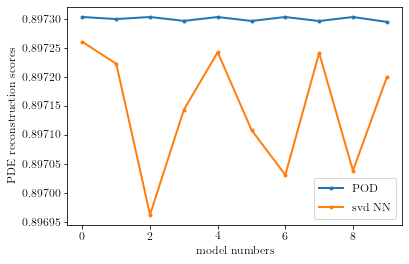

In [43]:
plt.plot(np.arange(0,K),POD_score_list, '.-', label="POD")
plt.plot(np.arange(0,K),svdNN_score_list, '.-',label="svd NN")
plt.xlabel("model numbers")
plt.ylabel("PDE reconstruction scores")
plt.legend()

#shape of NN curves will always change every run time
#svd model is always better
#maybe increase the number of iteration to make it closer to POD score

In [18]:
import sklearn
svdNN_rec_score = 0
for iii in range(0,K):  
  restored_data = restorePOD(a_svdNN_list[iii], w2svd, b2)
  svdNN_rec_score += sklearn.metrics.mean_squared_error(train_data_list[iii],restored_data)
svdNN_rec_score = svdNN_rec_score/K
print(1-svdNN_rec_score)

0.990313284844584


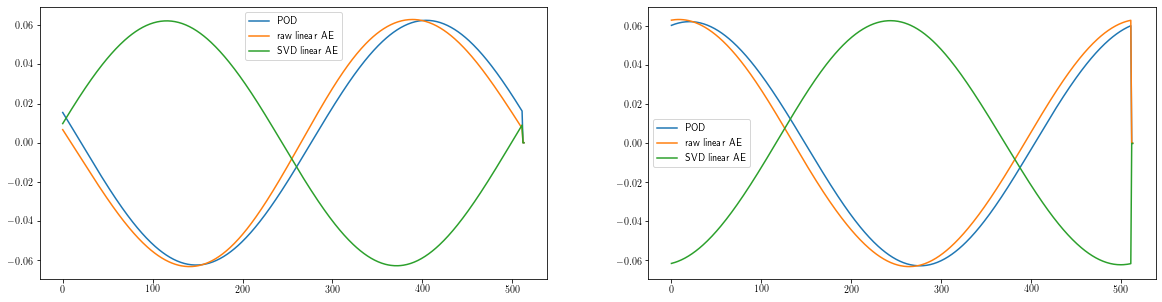

In [19]:
#Compare POD modes, raw NN modes, svd NN modes
fig = plt.figure(figsize=(20,5))
gs = gridspec.GridSpec(1,2)

ax = fig.add_subplot(gs[0])
plt.plot(U[:,0], label="POD")
plt.plot(w2[:,0], label="raw linear AE")
plt.plot(w2svd[:,0], label="SVD linear AE")
plt.legend()

ax = fig.add_subplot(gs[1])
plt.plot(U[:,1], label="POD")
plt.plot(w2[:,1], label="raw linear AE")
plt.plot(w2svd[:,1], label="SVD linear AE")
plt.legend()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: This function is deprecated. Please call randint(0, 9 + 1) instead
  


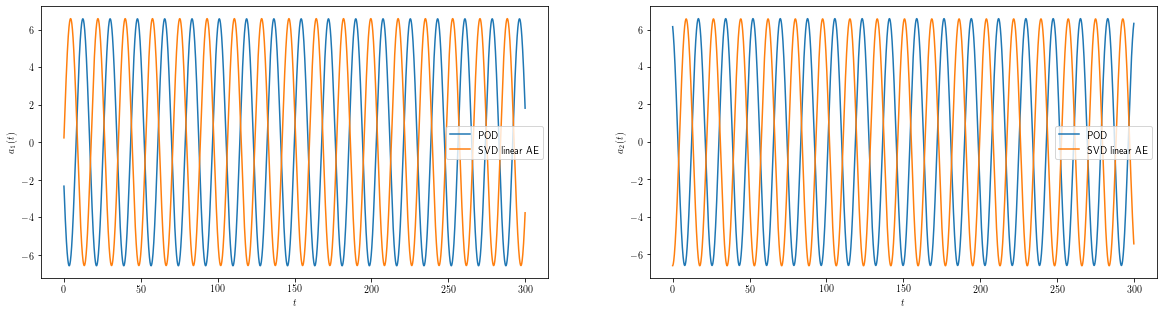

In [20]:
#Visualized reduced dimension data, note that SVD and POD have the same amplitude
random_int = np.random.random_integers(0,K-1)
fig = plt.figure(figsize=(20,5))
gs = gridspec.GridSpec(1,2)

ax = fig.add_subplot(gs[0])
plt.plot(t,a_POD_list[random_int][:,0],label="POD")
#plt.plot(t,a_rawNN_list[random_int][:,0],label="raw linear AE")
plt.plot(t,a_svdNN_list[random_int][:,0],label="SVD linear AE")
plt.xlabel("$t$")
plt.ylabel("$a_1(t)$")
plt.legend()

ax = fig.add_subplot(gs[1])
plt.plot(t,a_POD_list[random_int][:,1],label="POD")
#plt.plot(t,a_rawNN_list[random_int][:,1],label="raw linear AE")
plt.plot(t,a_svdNN_list[random_int][:,1],label="SVD linear AE")
plt.xlabel("$t$")
plt.ylabel("$a_2(t)$")
plt.legend()

In [21]:
#define count terms
def count_terms(model):
    coeffs = model.coefficients()
    zero_threshold = 1e-6
    new_coeffs = np.where(np.abs(coeffs)<zero_threshold, 0, coeffs)
    rowidx,colidx = np.nonzero(new_coeffs)
    num_terms = len(rowidx)
    #print(str(num_terms) + " nonzero coefficients in this system of DEs")
    return num_terms

#define score
def calc_score(model,Data,t):
    true_data = model.differentiate(Data,t)
    pred_data = model.predict(Data)
    xdotscore = r2_score(true_data, pred_data)
    #print("xdot score: " + str(xdotscore))
    
    return xdotscore

In [22]:
def integrateSINDy(model, t, InputData, dt):
    diffData = model.predict(InputData)
    rhs = lambda t,x: model.predict(x[np.newaxis,:])[0]
    SimData = np.zeros((len(t),np.shape(InputData)[1]))
    SimData[0,:] = InputData[0,:]
    for iii in range(1,len(t)):
        SimData[iii,:] = SimData[iii-1,:] + dt*diffData[iii,:]
    for iii in range(0,np.shape(InputData)[1]):
        f = lambda x, a, b: a*x + b
        vars, dummy = sp.optimize.curve_fit(f, t, SimData[:,iii])
        SimData[:,iii] = SimData[:,iii] - f(t,vars[0], vars[1])
        SimData[:,iii] = SimData[:,iii] - SimData[0,iii] + InputData[0,iii]
    return SimData

In [23]:
def plotSINDy(t,Data,t_int,SimData):

    #Plot SINDY simulation
    import matplotlib as mpl
    mpl.rcParams['lines.linewidth'] = 2
    mpl.rcParams['font.size'] = 14
    mpl.rcParams['text.usetex'] = True

    fig = plt.figure(figsize=(20,2*hidden_dim))
    gs = gridspec.GridSpec(hidden_dim,1)

    for iii in range(0,hidden_dim):
      ax = fig.add_subplot(gs[iii])
      ax.plot(t, Data[:, iii],"b", label=r"reduced data")
      ax.plot(t_int,SimData[:,iii], "r", label=r"SINDy interpolation of reduced data")
      ax.set_ylabel(feature_names[iii]+'(t)', fontsize = 20)
      if iii == 1:
        ax.legend(loc="lower right")

In [24]:
feature_names = []
for iii in range(0,hidden_dim):
    feature_names.append("a" + str(iii+1))
differentiation_method = ps.SmoothedFiniteDifference(order=1)
feature_library3 = ps.PolynomialLibrary(degree=3, include_bias = True)  

dt = 0.1
t = np.arange(0,300,dt)

In [25]:
def plot_tradeoff(alpha_range, scores, num_terms):
  fig, ax1 = plt.subplots()

  color = 'tab:red'
  ax1.set_xlabel('alpha')
  ax1.set_ylabel('x-dot score', color=color)
  ax1.plot(alpha_range, scores, '.-', color=color)
  ax1.tick_params(axis='y', labelcolor=color)

  ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
  color = 'tab:blue'
  ax2.set_ylabel('number of terms', color=color)  # we already handled the x-label with ax1
  ax2.plot(alpha_range, num_terms, '.-', color=color)
  ax2.tick_params(axis='y', labelcolor=color)

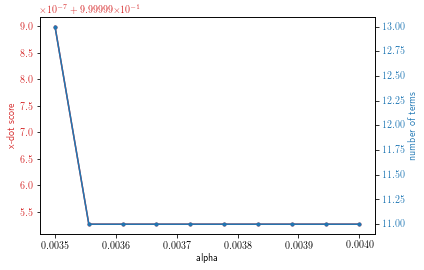

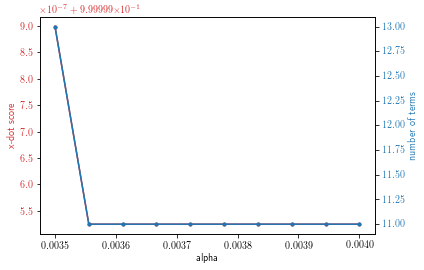

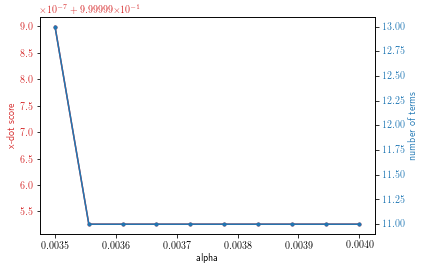

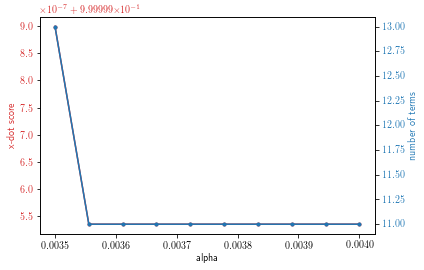

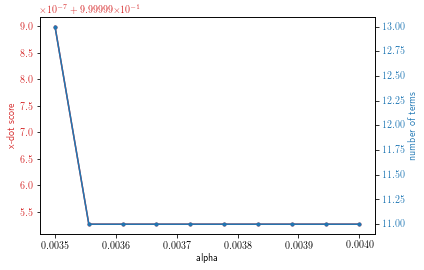

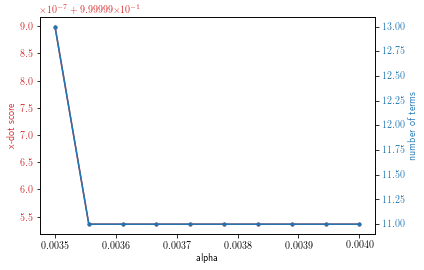

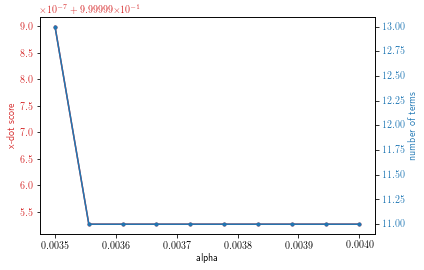

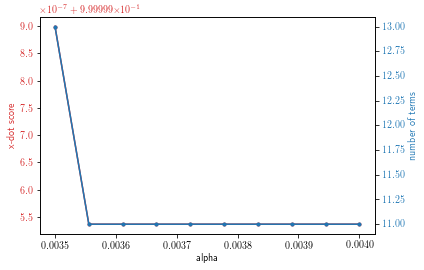

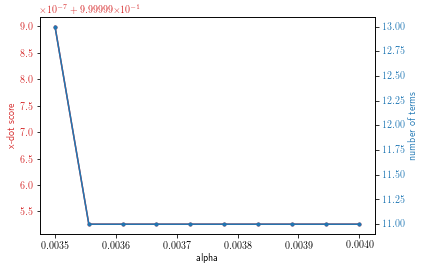

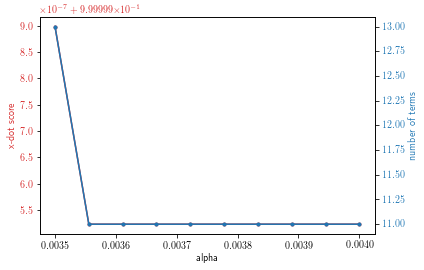

In [26]:
#find best SINDy equations for POD data

alpha_range = np.linspace(0.0035,0.0040,10)
POD_SINDy_alpha_list = []

for iii in range(0,K):
  alpha_score_list = []
  num_terms_list = []
  for jjj in range(0,len(alpha_range)):
    lasso_optimizer = Lasso(alpha=alpha_range[jjj], fit_intercept=False, selection="cyclic", max_iter = 2000)
    test_model = ps.SINDy(
      differentiation_method=differentiation_method,
      feature_library=feature_library3,
      optimizer= lasso_optimizer,
      feature_names=feature_names) 

    test_model.fit(a_POD_list[iii], t=t)
    alpha_score_list.append(calc_score(test_model,a_POD_list[iii],t))
    num_terms_list.append(count_terms(test_model))
  
  plot_tradeoff(alpha_range, alpha_score_list, num_terms_list)
  POD_SINDy_alpha_list.append(alpha_range[np.argmin(num_terms_list)])

In [27]:
#cross validation to find the best model
model_score_list = []
for (test,train) in kfold.split(train_data_list):
    lasso_optimizer = Lasso(alpha=0.0035, 
                            fit_intercept=False, 
                            selection="cyclic", 
                            max_iter = 2000)
    test_model = ps.SINDy(
      differentiation_method=differentiation_method,
      feature_library=feature_library3,
      optimizer= lasso_optimizer,
      feature_names=feature_names) 

    test_model.fit(a_POD_list[train[0]], t=t)
    val_score = 0
    for iii in test:
      val_score += calc_score(test_model,a_POD_list[iii],t)
    model_score_list.append(val_score/(K-1))

best_idx = np.argmax(model_score_list)
POD_model = ps.SINDy(
      differentiation_method=differentiation_method,
      feature_library=feature_library3,
      optimizer= lasso_optimizer,
      feature_names=feature_names) 
POD_model.fit(a_POD_list[best_idx],t=t)
POD_model.print(precision=6)
POD_model.optimizer

a1' = -0.359740 a2 + 0.000062 a1^2 + -0.000061 a2^2 + -0.000144 a1^3 + 0.000133 a1^2 a2 + -0.000144 a1 a2^2 + 0.000133 a2^3
a2' = 0.312416 a1 + -0.000277 a1 a2 + 0.000955 a1^3 + -0.000144 a1^2 a2 + 0.000954 a1 a2^2 + -0.000144 a2^3


Lasso(alpha=0.0035, fit_intercept=False, max_iter=2000)

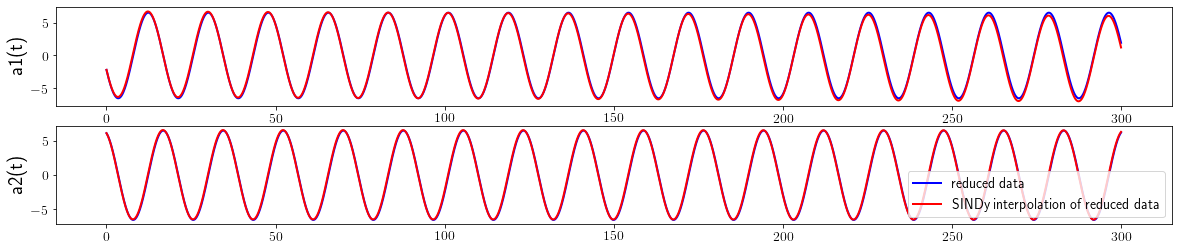

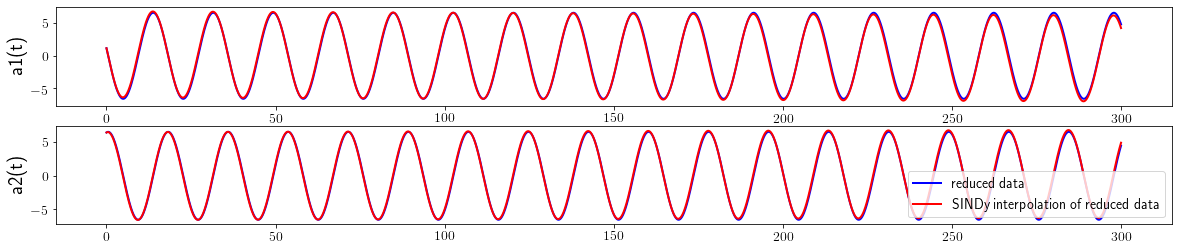

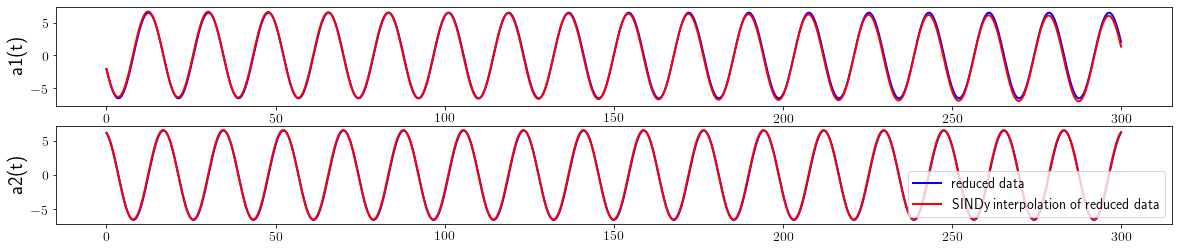

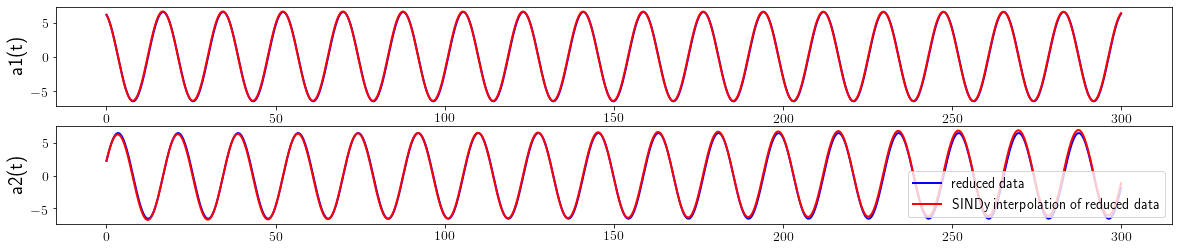

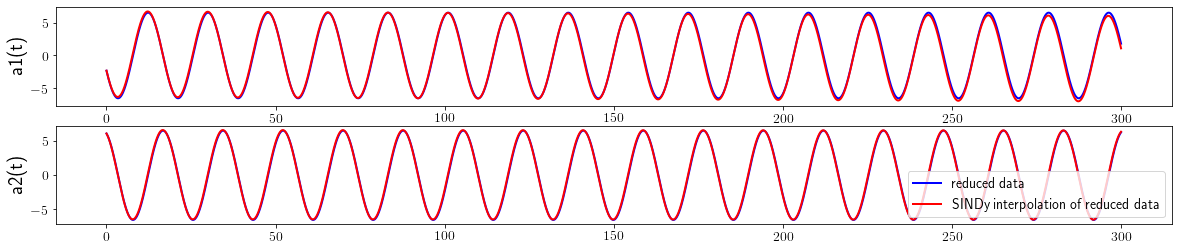

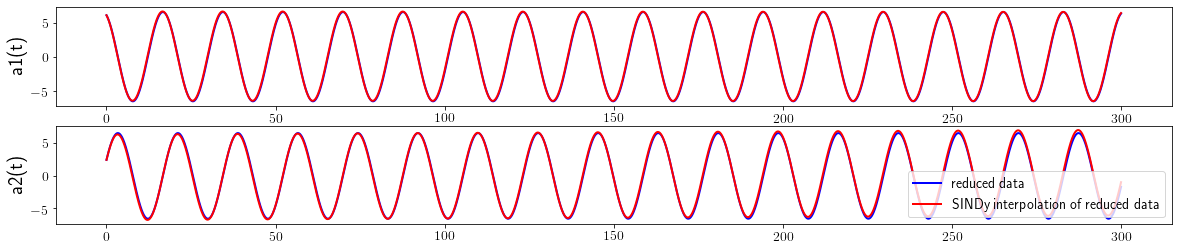

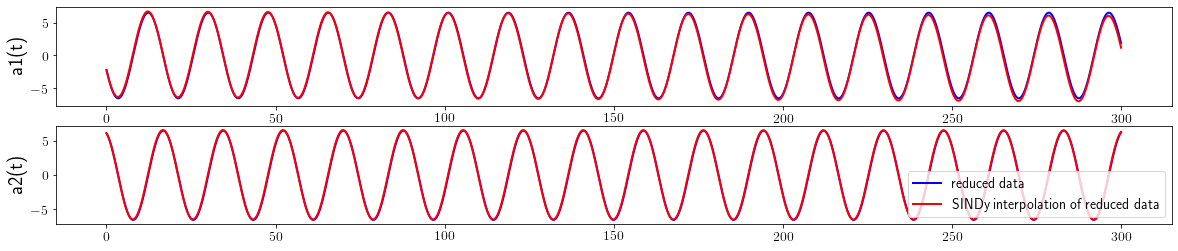

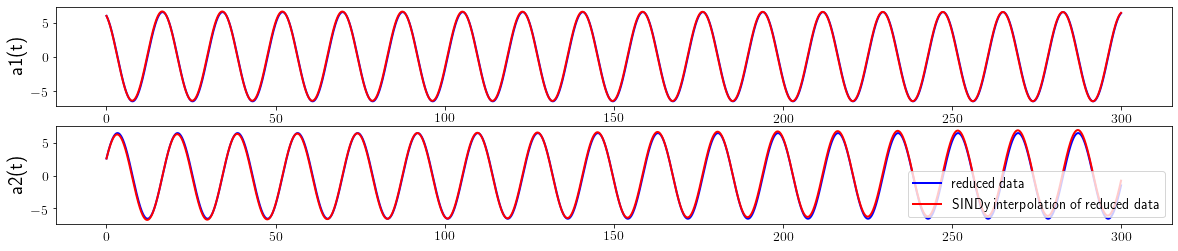

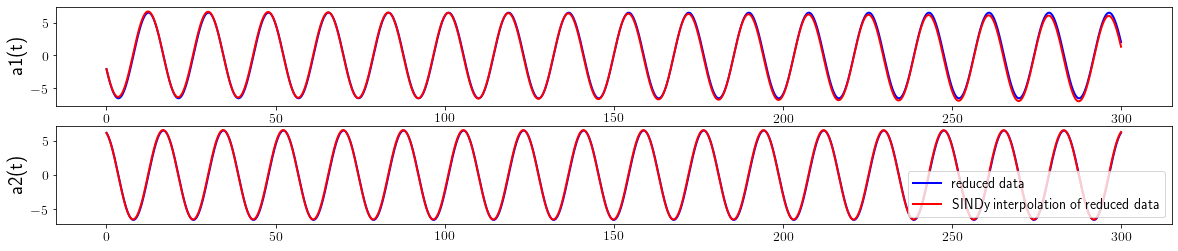

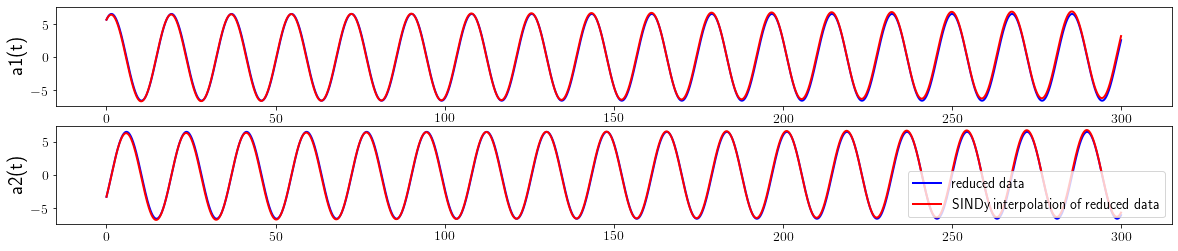

In [28]:
restored_POD_data_list = []
for iii in range(0,K):
  SimData = integrateSINDy(POD_model, t, a_POD_list[iii], dt)
  plotSINDy(t,a_POD_list[iii],t,SimData)
  restored_POD_data_list.append(restorePOD(SimData, U_POD, b_POD))

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


0.8949736100000146


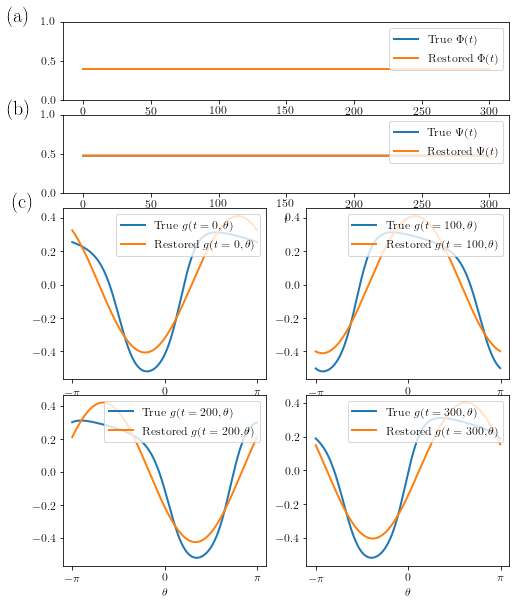

In [29]:
iii = np.random.randint(0,K)
plot_restored(train_data_list[iii],restored_POD_data_list[iii])
plt.savefig('PODreconstruction.pdf')

POD_rec_score = 0
for iii in range(0,K):  
  POD_rec_score += r2_score(train_data_list[iii][:,0:-2],restored_POD_data_list[iii][:,0:-2])
POD_rec_score = POD_rec_score/K
print(POD_rec_score)

In [57]:
#find best SINDy equations for raw NN data
alpha_range = np.linspace(0.01,0.02,11)
rawNN_SINDy_alpha_list = []

for iii in range(0,K):
  alpha_score_list = []
  num_terms_list = []
  for jjj in range(0,len(alpha_range)):
    lasso_optimizer = Lasso(alpha=alpha_range[jjj], fit_intercept=False, selection="cyclic", max_iter = 2000)
    test_model = ps.SINDy(
      differentiation_method=differentiation_method,
      feature_library=feature_library3,
      optimizer= lasso_optimizer,
      feature_names=feature_names) 

    test_model.fit(a_rawNN_list[iii], t=t)
    alpha_score_list.append(calc_score(test_model,a_rawNN_list[iii],t))
    num_terms_list.append(count_terms(test_model))
  
  plot_tradeoff(alpha_range, alpha_score_list, num_terms_list)
  rawNN_SINDy_alpha_list.append(alpha_range[np.argmin(num_terms_list)])

IndexError: ignored

In [ ]:
#cross validation to find the best model
model_score_list = []
for (test,train) in kfold.split(train_data_list):
    lasso_optimizer = Lasso(alpha=rawNN_SINDy_alpha_list[train[0]], 
                            fit_intercept=False, 
                            selection="cyclic", 
                            max_iter = 2000)
    test_model = ps.SINDy(
      differentiation_method=differentiation_method,
      feature_library=feature_library3,
      optimizer= lasso_optimizer,
      feature_names=feature_names) 
    test_model.fit(a_rawNN_list[train[0]], t=t)
    val_score = 0
    for iii in test:
      val_score += calc_score(test_model,a_rawNN_list[iii],t)
    model_score_list.append(val_score/(K-1))

best_idx = np.argmax(model_score_list)
rawNN_model = ps.SINDy(
      differentiation_method=differentiation_method,
      feature_library=feature_library3,
      optimizer= lasso_optimizer,
      feature_names=feature_names) 
rawNN_model.fit(a_rawNN_list[best_idx],t=t)
rawNN_model.print(precision=6)

a1' = 0.000377 a1^2 + -0.000189 a1^3 + -0.008558 a1^2 a2 + -0.000268 a1 a2^2 + -0.008564 a2^3
a2' = -0.000320 a1^2 + 0.008550 a1^3 + 0.008554 a1 a2^2 + -0.000120 a2^3


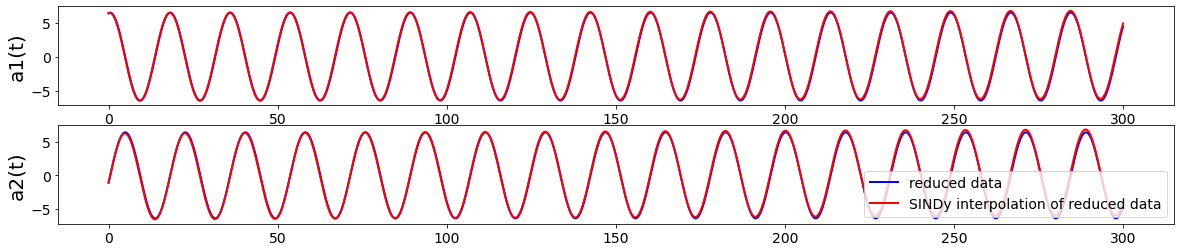

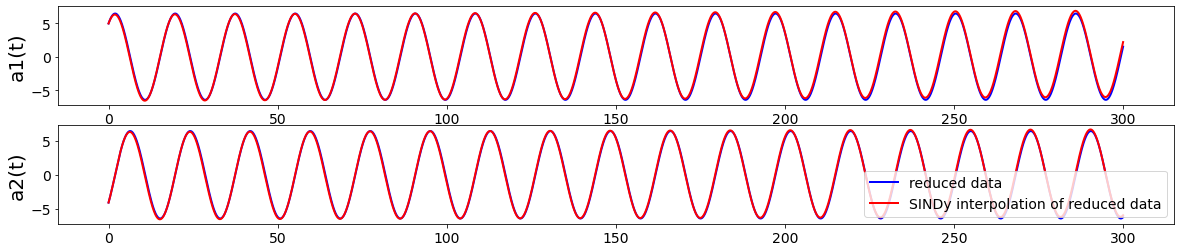

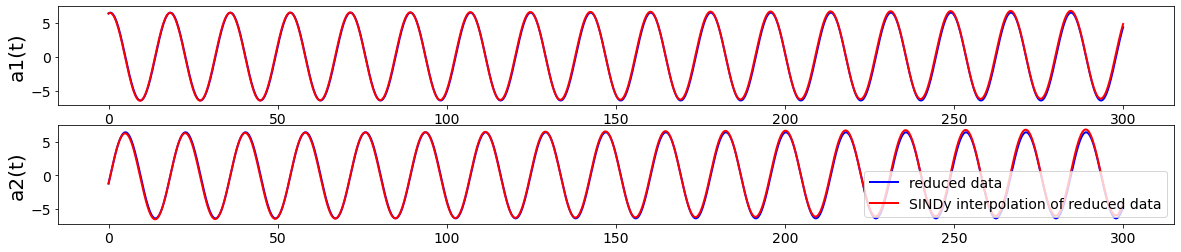

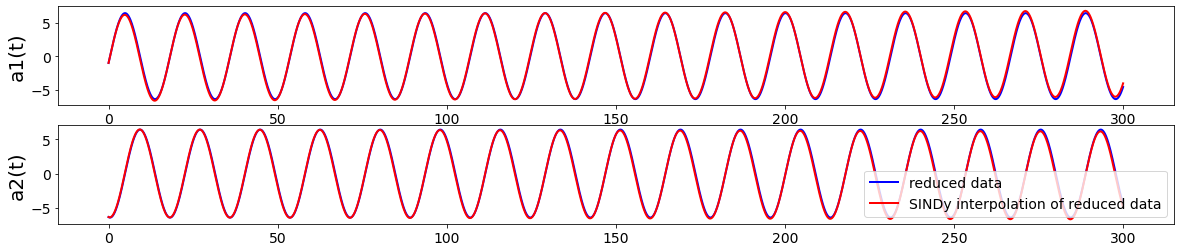

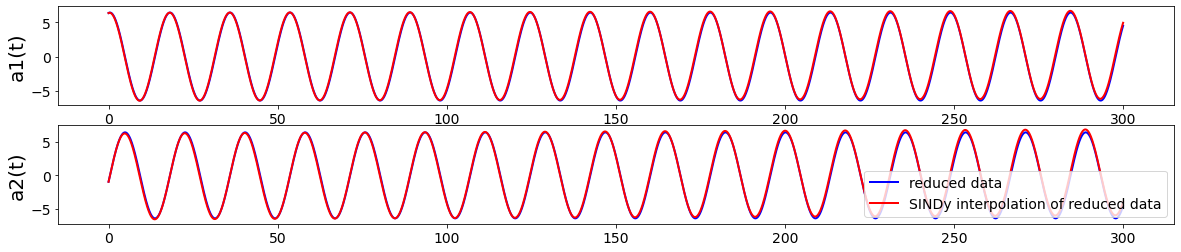

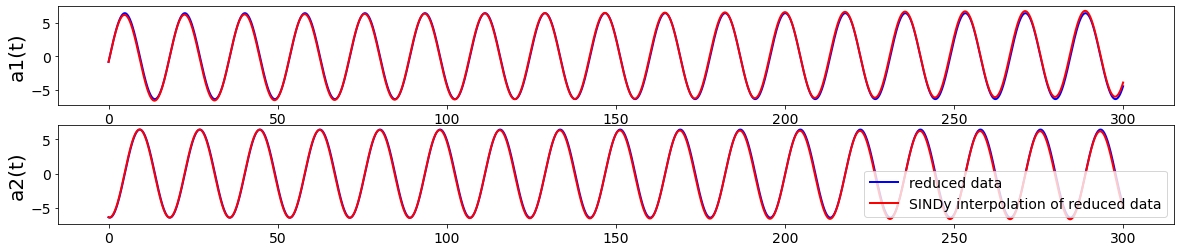

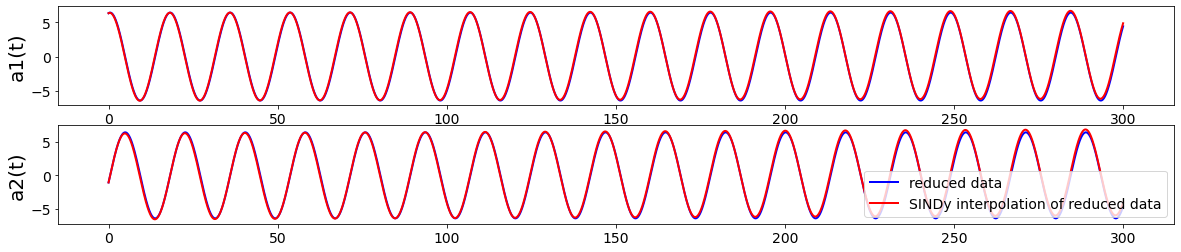

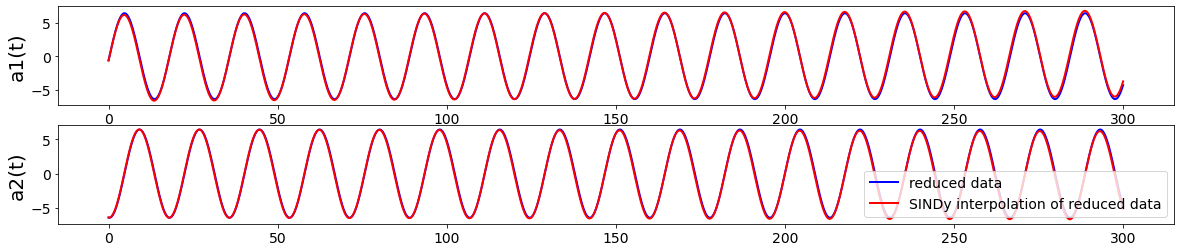

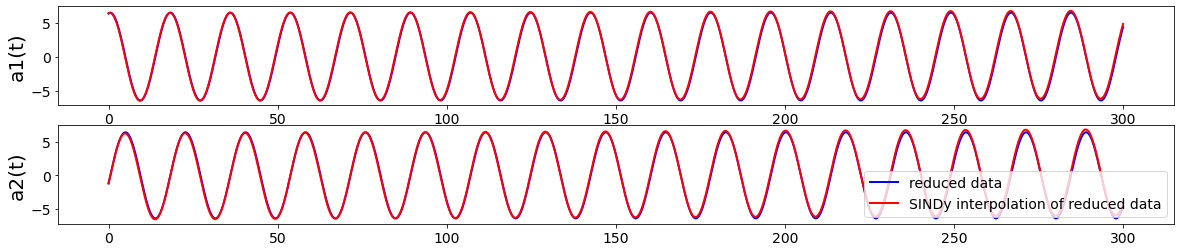

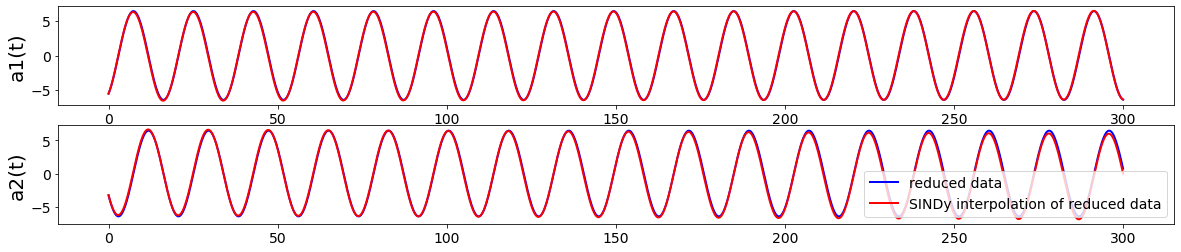

In [ ]:
restored_rawNN_data_list = []
for iii in range(0,K):
  SimData = integrateSINDy(rawNN_model, t, a_rawNN_list[iii], dt)
  plotSINDy(t,a_rawNN_list[iii],t,SimData)
  restored_rawNN_data_list.append(restorePOD(SimData, w2, bias=b2))

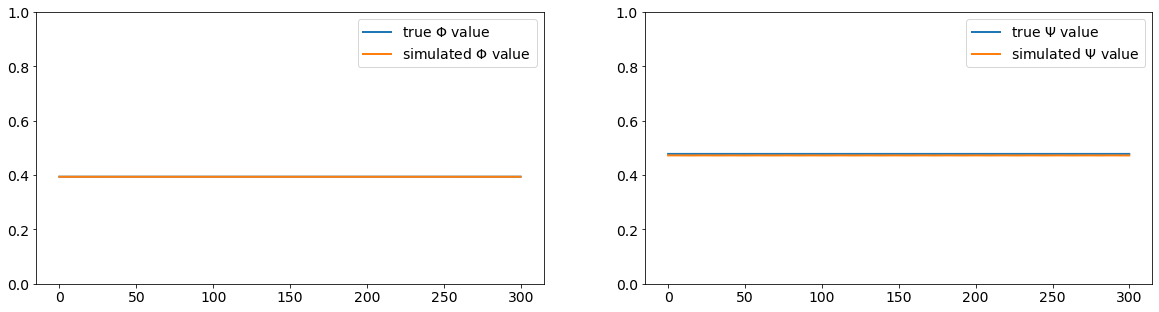

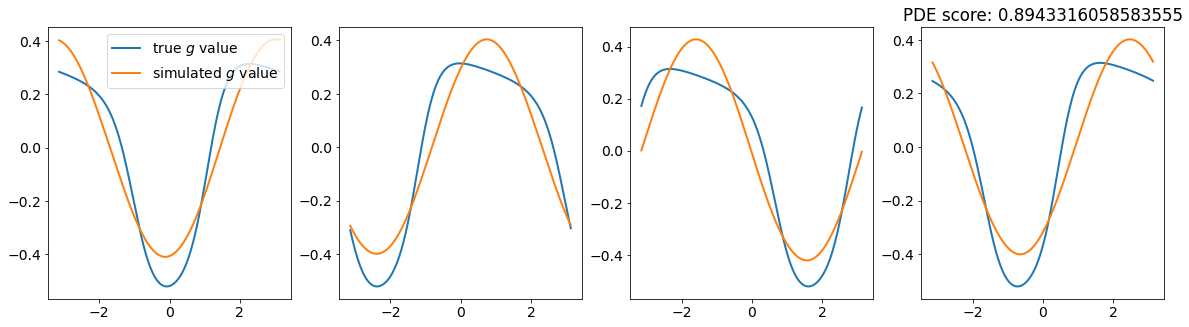

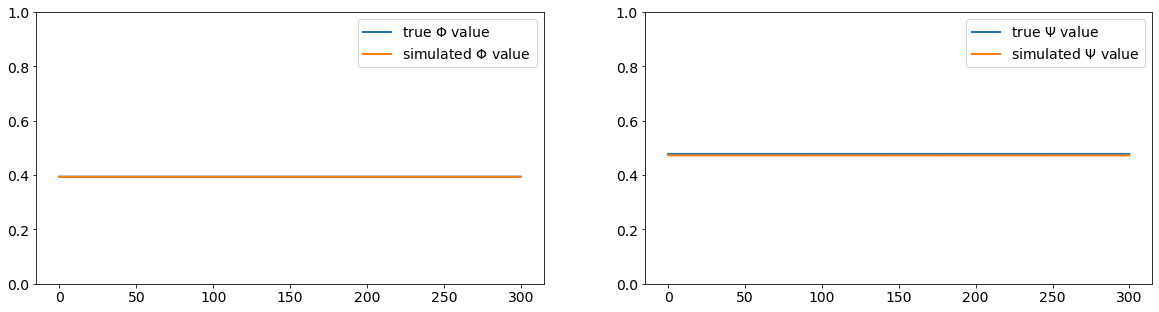

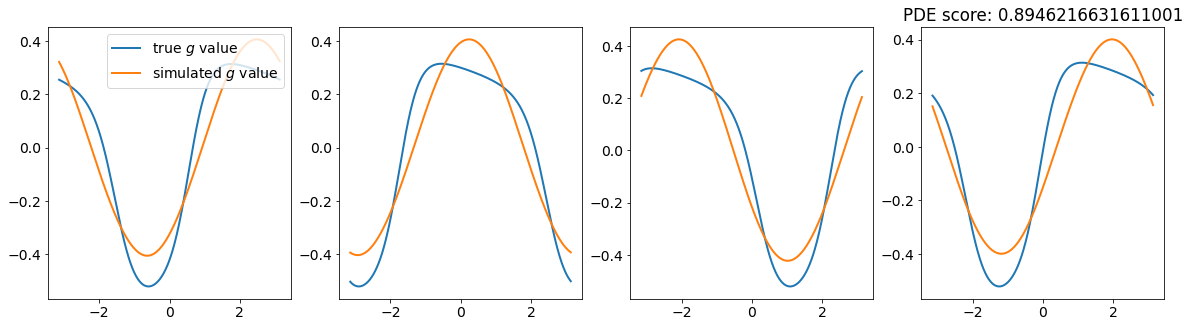

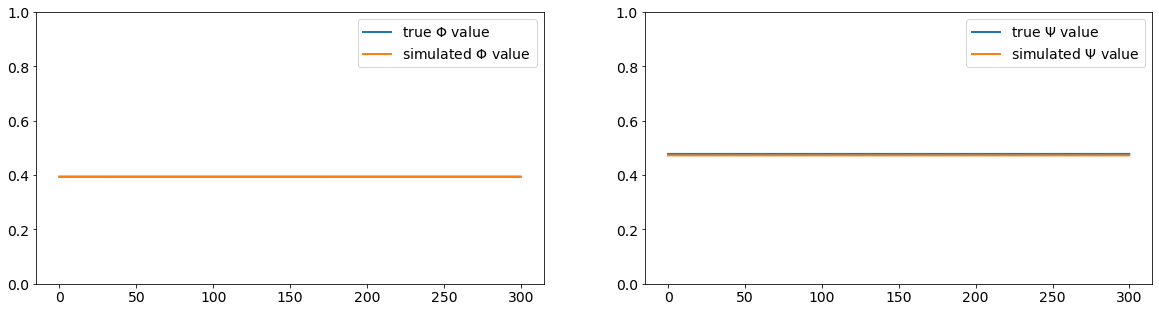

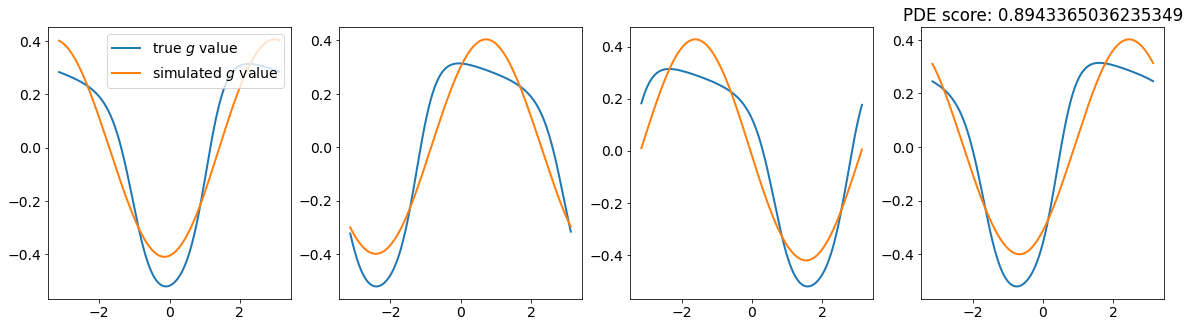

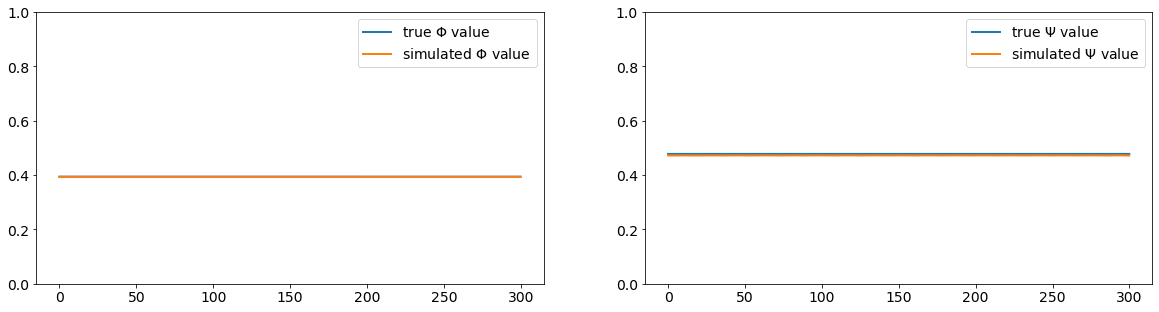

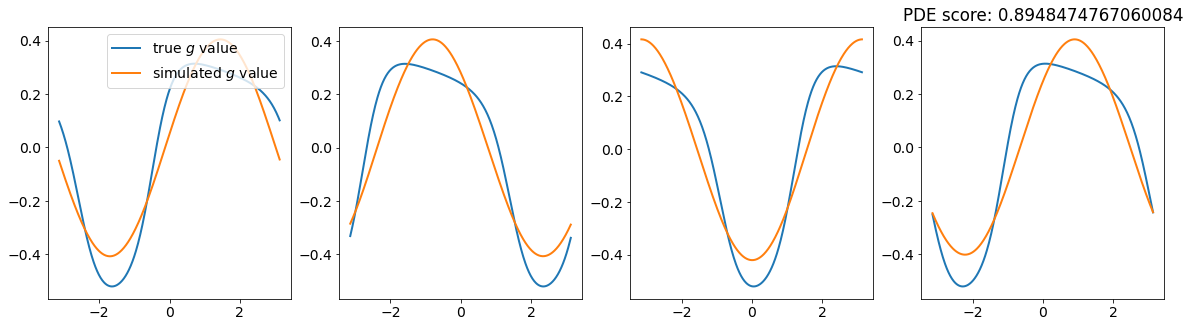

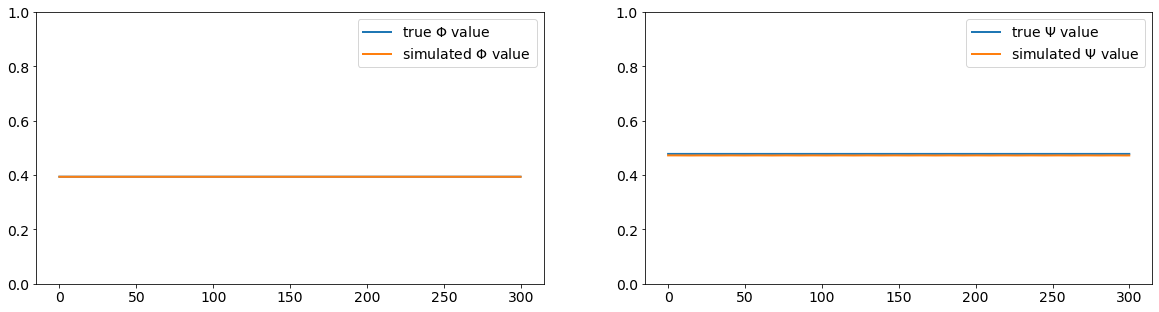

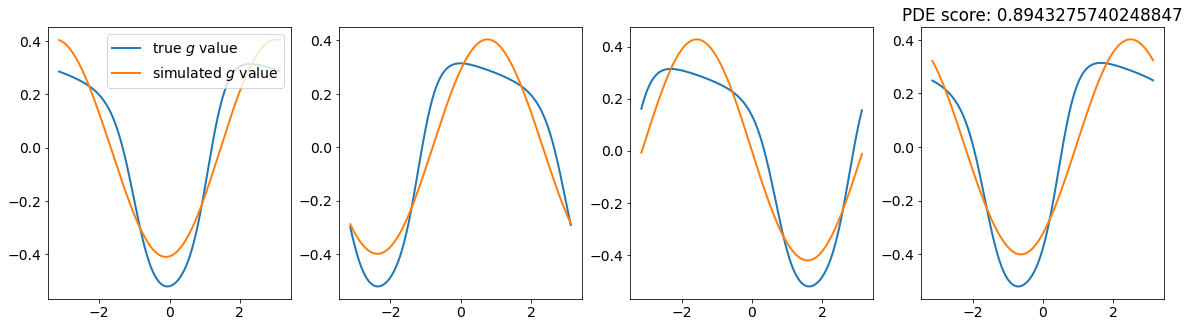

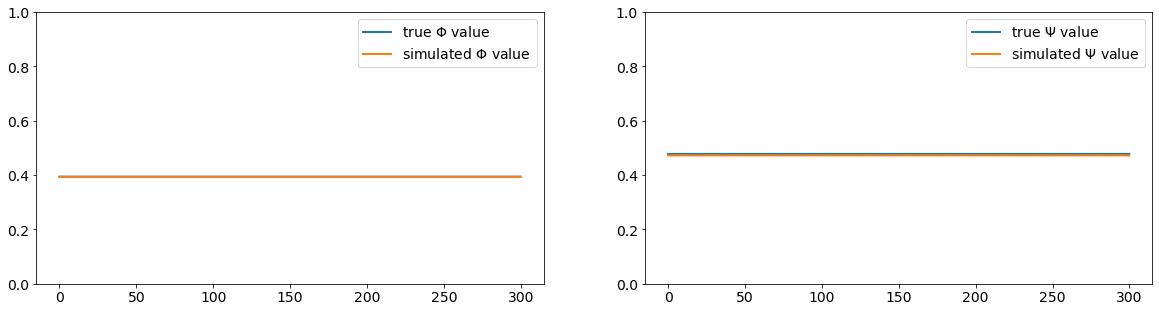

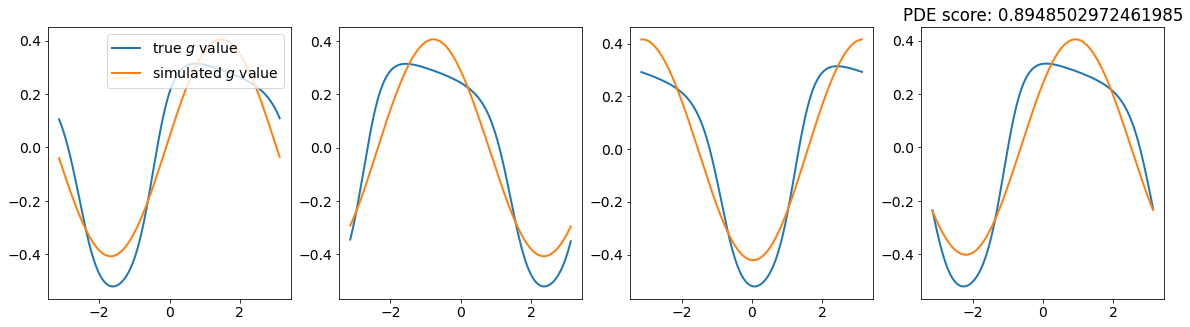

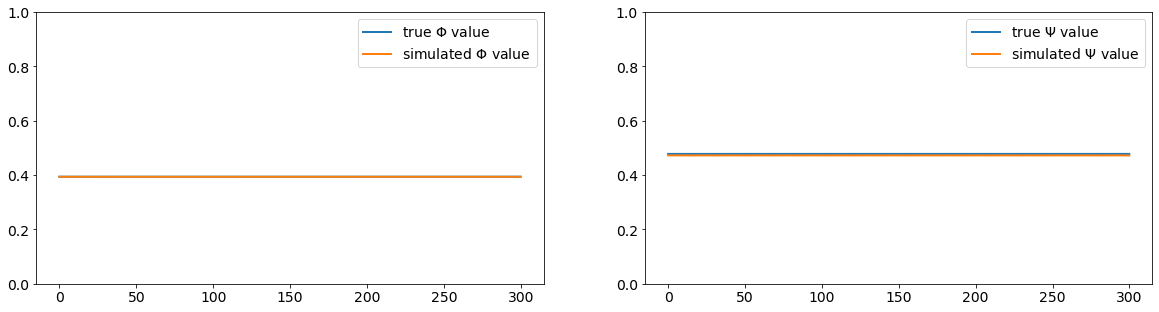

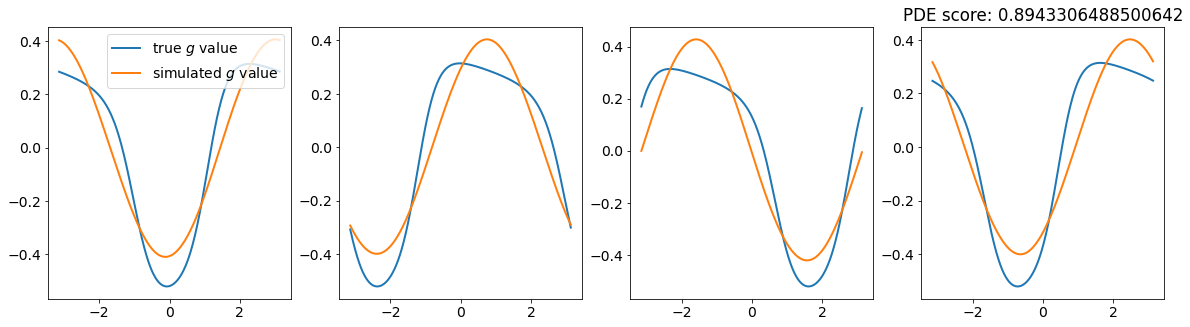

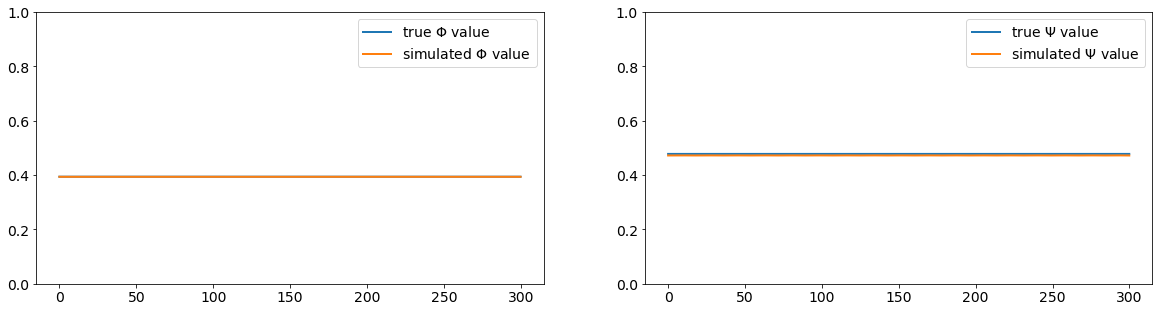

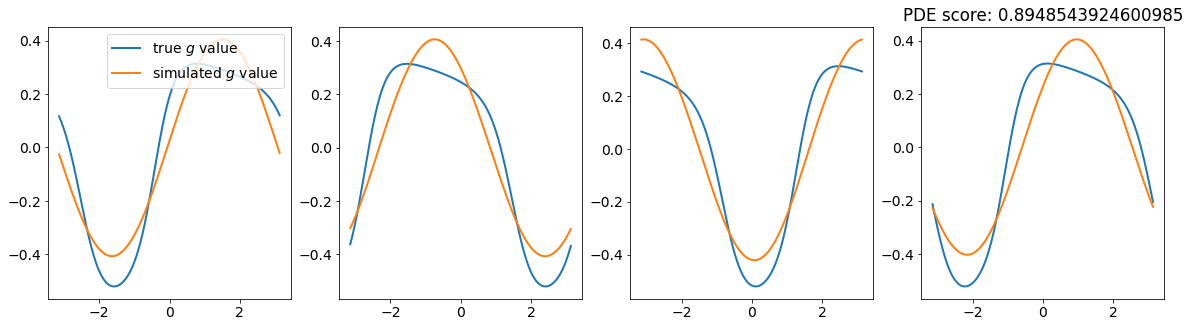

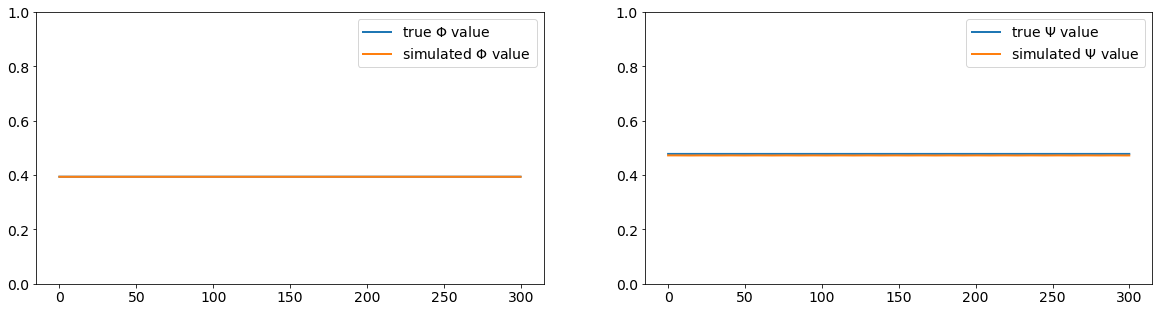

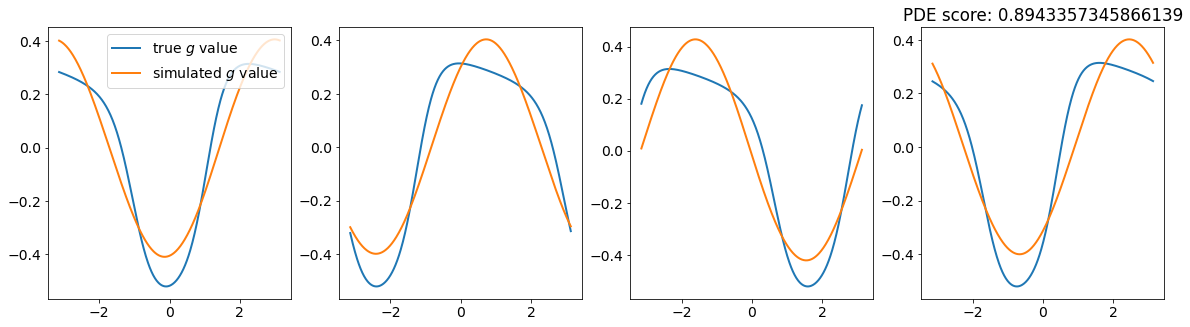

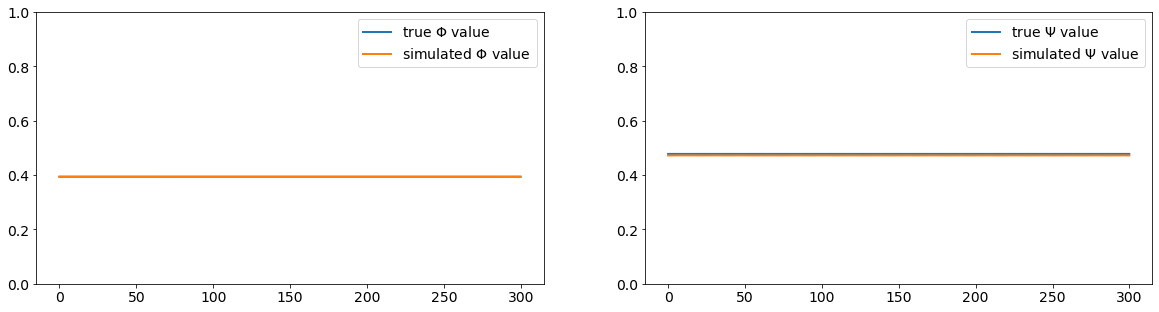

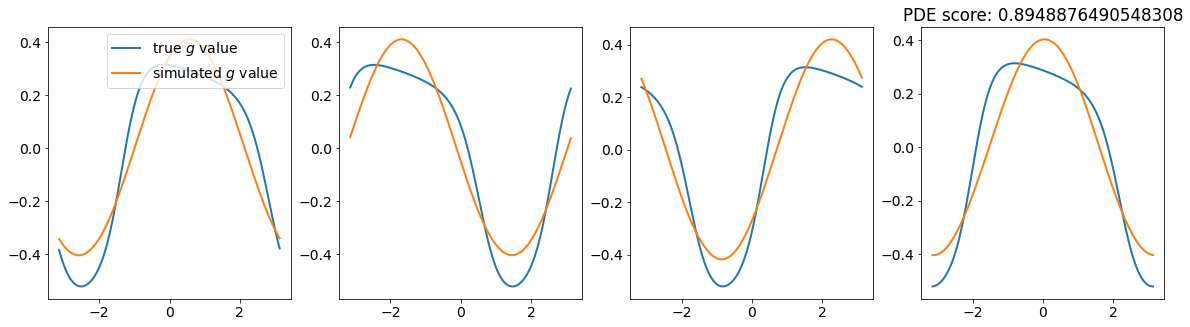

In [ ]:
for iii in range(0,K):
  plot_restored(train_data_list[iii],restored_rawNN_data_list[iii])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9560235566987251, tolerance: 0.8217337870840528
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9513612923930299, tolerance: 0.8135778233847828
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0235508577431822, tolerance: 0.8217337870840528
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0152

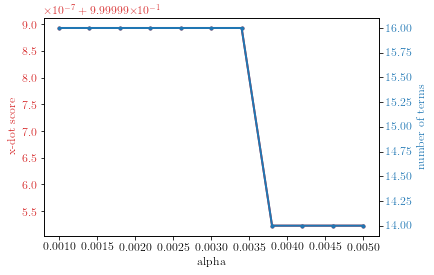

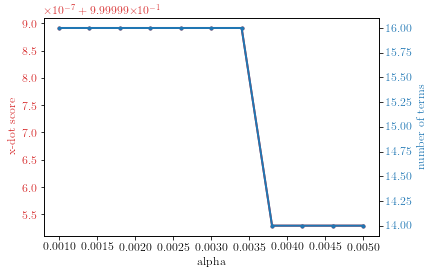

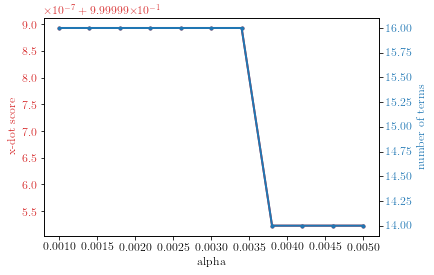

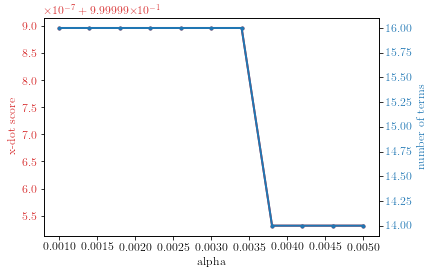

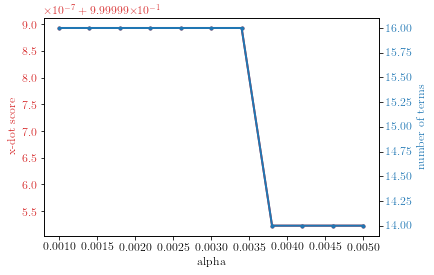

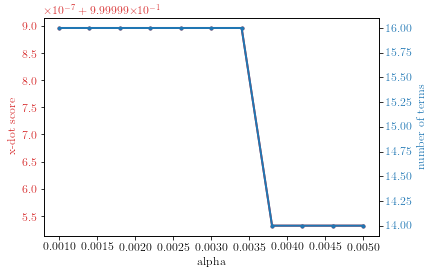

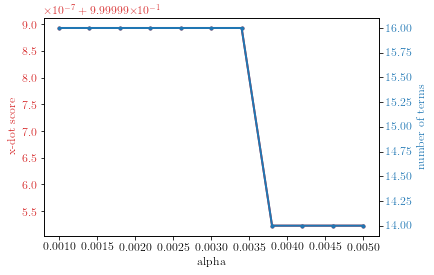

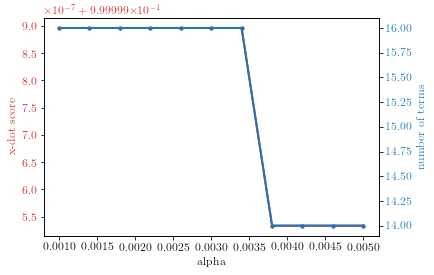

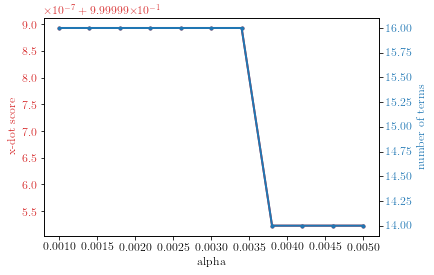

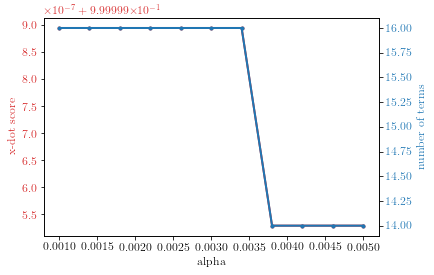

In [44]:
#find best SINDy equations for svd NN data
alpha_range = np.linspace(0.001,0.005,11)
svdNN_SINDy_alpha_list = []

for iii in range(0,K):
  alpha_score_list = []
  num_terms_list = []
  for jjj in range(0,len(alpha_range)):
    lasso_optimizer = Lasso(alpha=alpha_range[jjj], fit_intercept=False, selection="cyclic", max_iter = 2000)
    test_model = ps.SINDy(
      differentiation_method=differentiation_method,
      feature_library=feature_library3,
      optimizer= lasso_optimizer,
      feature_names=feature_names) 

    test_model.fit(a_svdNN_list[iii], t=t)
    alpha_score_list.append(calc_score(test_model,a_svdNN_list[iii],t))
    num_terms_list.append(count_terms(test_model))
  
  plot_tradeoff(alpha_range, alpha_score_list, num_terms_list)
  svdNN_SINDy_alpha_list.append(alpha_range[np.argmin(num_terms_list)])

In [45]:
#cross validation to find the best model
model_score_list = []
for (test,train) in kfold.split(train_data_list):
    lasso_optimizer = Lasso(alpha=0.0035, 
                            fit_intercept=False, 
                            selection="cyclic", 
                            max_iter = 2000)
    test_model = ps.SINDy(
      differentiation_method=differentiation_method,
      feature_library=feature_library3,
      optimizer= lasso_optimizer,
      feature_names=feature_names) 
    test_model.fit(a_svdNN_list[train[0]], t=t)
    val_score = 0
    for iii in test:
      val_score += calc_score(test_model,a_svdNN_list[iii],t)
    model_score_list.append(val_score/(K-1))

best_idx = np.argmax(model_score_list)
svdNN_model = ps.SINDy(
      differentiation_method=differentiation_method,
      feature_library=feature_library3,
      optimizer= lasso_optimizer,
      feature_names=feature_names) 
svdNN_model.fit(a_svdNN_list[best_idx],t=t)
svdNN_model.print(precision=6)
svdNN_SINDy_alpha_list[best_idx]

a1' = -0.269820 a2 + -0.000089 a1^2 + -0.000029 a1 a2 + 0.000076 a2^2 + -0.000144 a1^3 + -0.001934 a1^2 a2 + -0.000144 a1 a2^2 + -0.001934 a2^3
a2' = 0.391646 a1 + -0.000253 a1^2 + -0.000288 a1 a2 + 0.000161 a2^2 + -0.000867 a1^3 + -0.000145 a1^2 a2 + -0.000867 a1 a2^2 + -0.000144 a2^3


0.0038

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


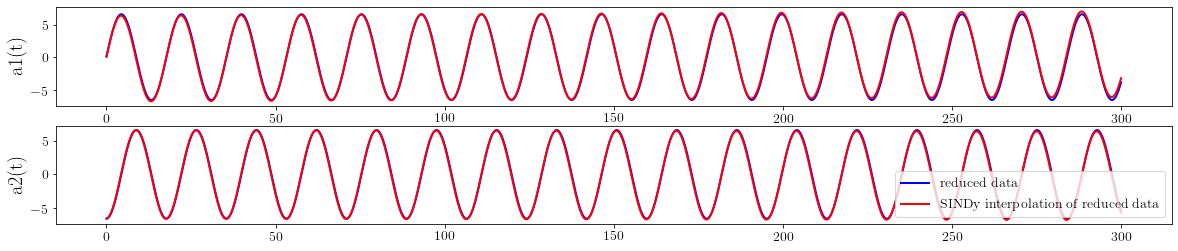

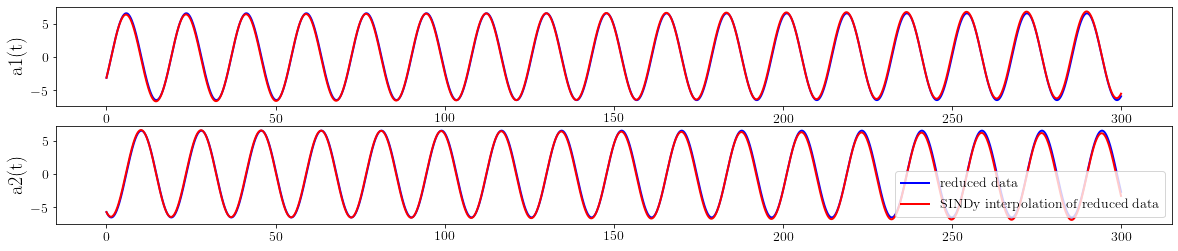

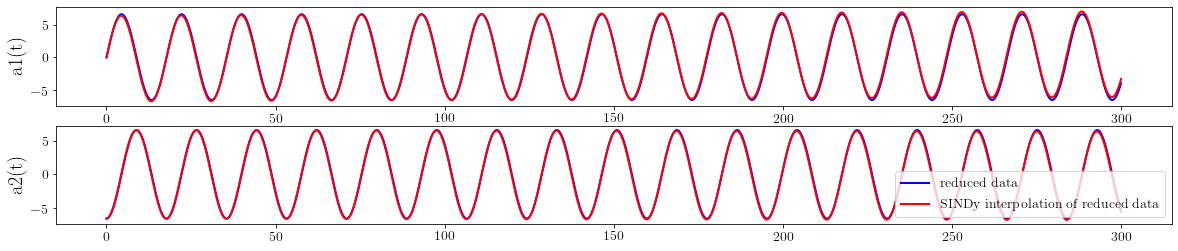

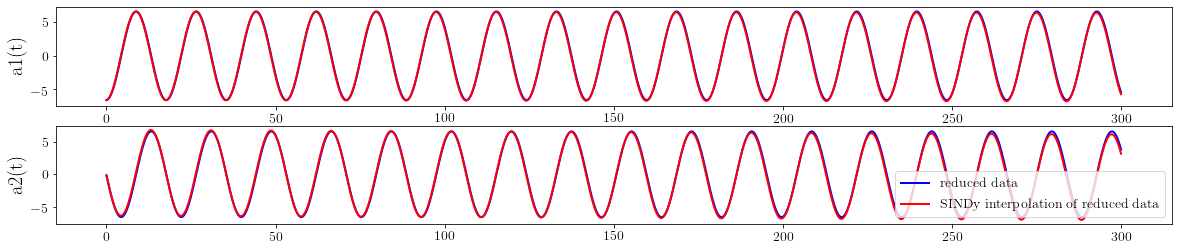

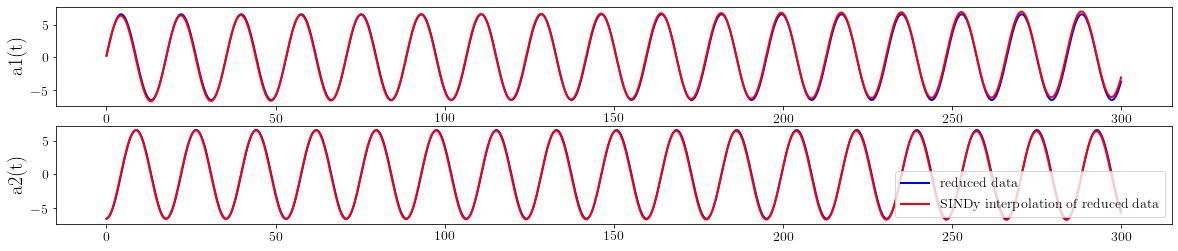

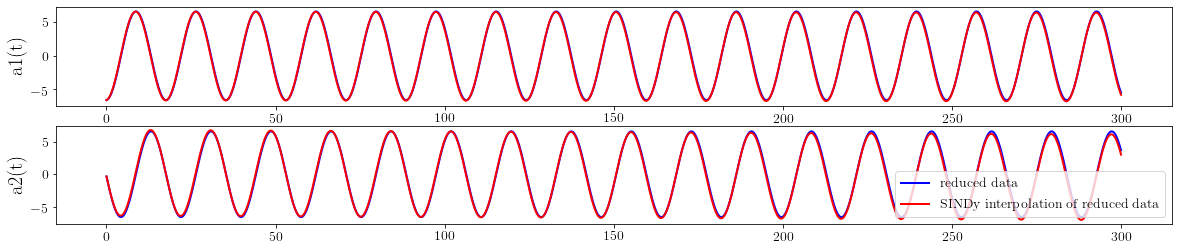

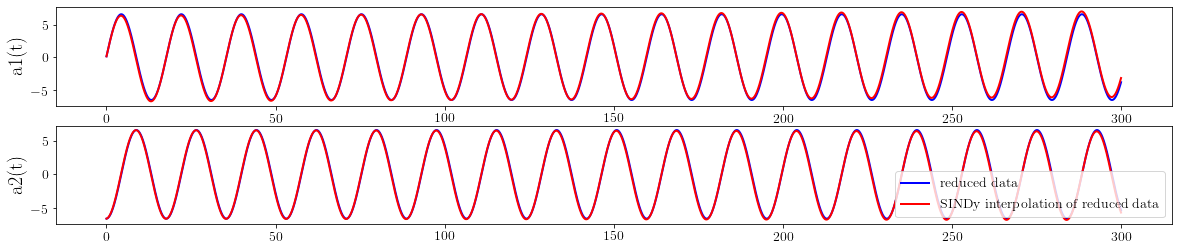

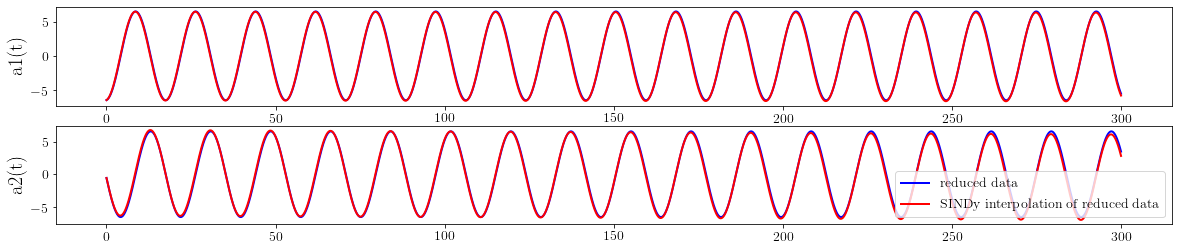

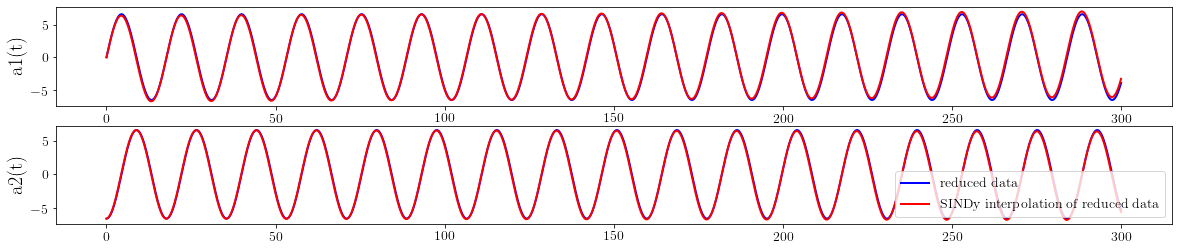

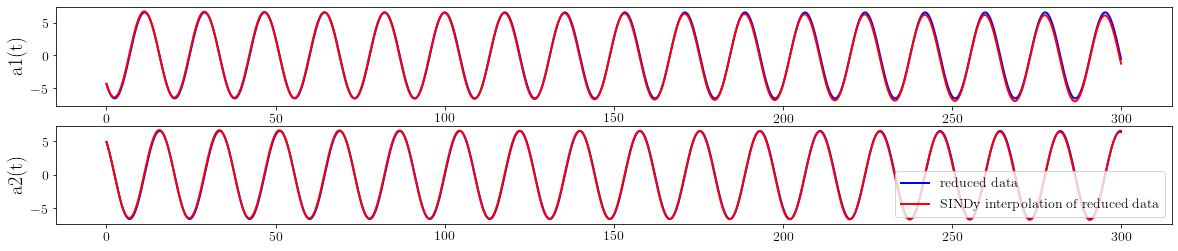

In [35]:
restored_svdNN_data_list = []
for iii in range(0,K):
  SimData = integrateSINDy(svdNN_model, t, a_svdNN_list[iii], dt)
  plotSINDy(t,a_svdNN_list[iii],t,SimData)
  restored_svdNN_data_list.append(restorePOD(SimData, w2svd, bias=b2))

3


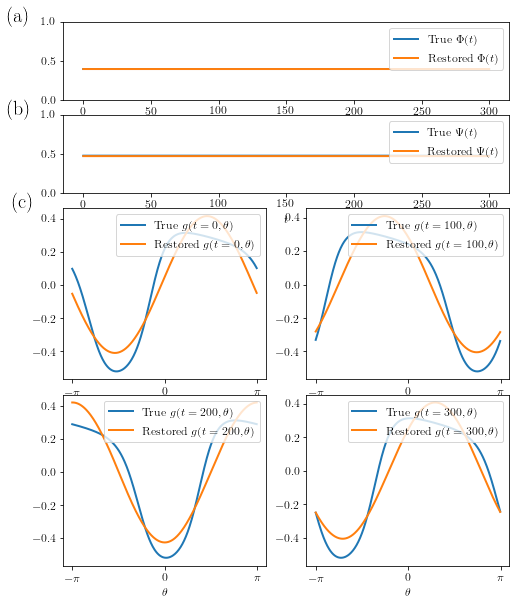

In [38]:
iii = np.random.randint(0,K)
print(iii)
plot_restored(train_data_list[iii],restored_svdNN_data_list[iii])
plt.savefig('svdNNreconstruction.pdf')

In [70]:
svdNN_rec_score = 0
for iii in range(0,K):  
  restored_data = restorePOD(a_svdNN_list[iii], w2svd, b2)
  svdNN_rec_score += r2_score(train_data_list[iii][:,0:-2],restored_data[:,0:-2])
svdNN_rec_score = svdNN_rec_score/K
print(svdNN_rec_score)

svdNN_rec_score = 0
for iii in range(0,K):  
  svdNN_rec_score += r2_score(train_data_list[iii][:,0:-2],restored_svdNN_data_list[iii][:,0:-2])
svdNN_rec_score = svdNN_rec_score/K
print(svdNN_rec_score)

0.8972947705072899
0.8948397493529383


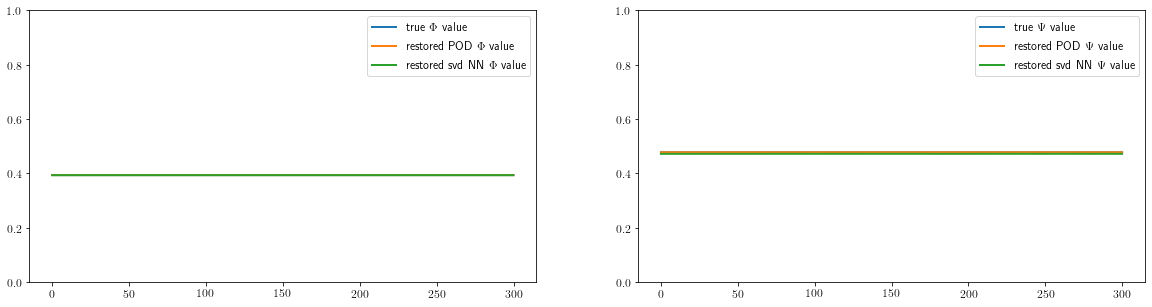

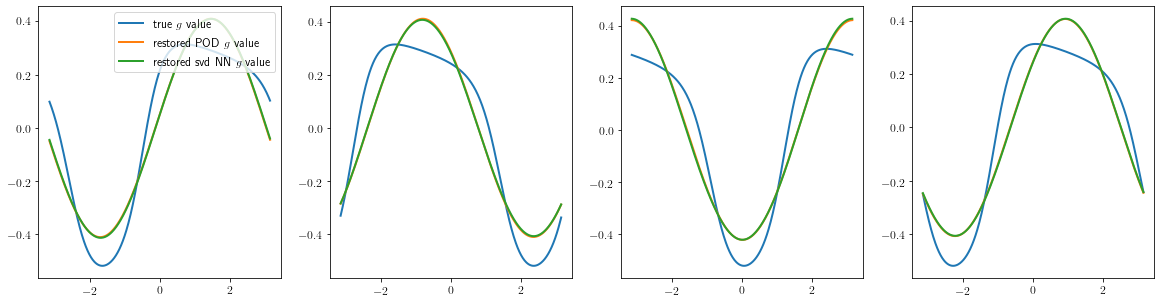

In [ ]:
tht = np.linspace(-np.pi, np.pi, 512)

G = train_data_list[random_int][:,0:-2]
Phi = train_data_list[random_int][:,-2]
Psi = train_data_list[random_int][:,-1]

POD_G = restored_POD_data_list[random_int][:,0:-2]
POD_Phi = restored_POD_data_list[random_int][:,-2]
POD_Psi = restored_POD_data_list[random_int][:,-1]

#rawNN_G = restored_rawNN_data_list[random_int][:,0:-2]
#rawNN_Phi = restored_rawNN_data_list[random_int][:,-2]
#rawNN_Psi = restored_rawNN_data_list[random_int][:,-1]

svdNN_G = restored_svdNN_data_list[random_int][:,0:-2]
svdNN_Phi = restored_svdNN_data_list[random_int][:,-2]
svdNN_Psi = restored_svdNN_data_list[random_int][:,-1]

fig = plt.figure(figsize=(20,5))
gs = gridspec.GridSpec(1,2)

ax = fig.add_subplot(gs[0])
plt.plot(t,Phi,label=r'true $\Phi$ value')
plt.plot(t,POD_Phi,label=r'restored POD $\Phi$ value')
#plt.plot(t,rawNN_Phi,label=r'restored raw NN $\Phi$ value')
plt.plot(t,svdNN_Phi,label=r'restored svd NN $\Phi$ value')
plt.ylim(0,1)
plt.legend()

ax = fig.add_subplot(gs[1])
plt.plot(t,Psi,label=r'true $\Psi$ value')
plt.plot(t,POD_Psi,label=r'restored POD $\Psi$ value')
#plt.plot(t,rawNN_Psi,label=r'restored raw NN $\Psi$ value')
plt.plot(t,svdNN_Psi,label=r'restored svd NN $\Psi$ value')
plt.ylim(0,1)
plt.legend()
    
fig = plt.figure(figsize=(20,5))
gs = gridspec.GridSpec(1,4)
ax = fig.add_subplot(gs[0])
plt.plot(tht,G[0*10,:],label=r'true $g$ value')
plt.plot(tht,POD_G[0*10,:],label=r'restored POD $g$ value')
#plt.plot(tht,rawNN_G[0*10,:],label=r'restored raw NN $g$ value')
plt.plot(tht,svdNN_G[0*10,:],label=r'restored svd NN $g$ value')
plt.legend(loc='upper right')
ax = fig.add_subplot(gs[1])
plt.plot(tht,G[1000,:])
plt.plot(tht,POD_G[1000,:])
#plt.plot(tht,rawNN_G[1000,:])
plt.plot(tht,svdNN_G[1000,:])
ax = fig.add_subplot(gs[2])
plt.plot(tht,G[2000,:])
plt.plot(tht,POD_G[2000,:])
#plt.plot(tht,rawNN_G[2000,:])
plt.plot(tht,svdNN_G[2000,:])
ax = fig.add_subplot(gs[3])
plt.plot(tht,G[3000-1,:])
plt.plot(tht,POD_G[3000-1,:])
#plt.plot(tht,rawNN_G[3000-1,:])
plt.plot(tht,svdNN_G[3000-1,:])